In [13]:

import os #Pour le Mapping 
import h5py #Stockage du data 
import librosa # for music and audio analysis
import itertools #Function creating iterators  
from copy import copy 
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict #store collections of data
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [14]:
#Importer les biblios relatifs au tensorflow 
import tensorflow as tf
#Importer les couches du CNN from keras 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Read the data

Lire le data , diviser et retourner un tableau de melspectrograms

In [16]:
#Diviser la music en mourceau en utilisant overlapping windows
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Diviser et créer des nouveaux mourceaux 
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [17]:
#Convertir une liste de musiques en array de melspectograms 
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Fonction de transformation 
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft, hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # melspectrogram avec log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [18]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convertir en spectrograms et diviser en petits windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # dataset de melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Enregistrer les fichiers 
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [19]:
def read_data(src_dir, genres, song_samples):    

    arr_fn = []
    arr_genres = []

    # Mapper les fichiers de chaque dossier 
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                #Enregistrer le nom de fichier et le genre correspondant 
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    #Diviser en train et test 
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Diviser en petit segments et convertir en spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
#Path
gtzan_dir = '../CNN/genres/'
#Paramètres 
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27300, 128, 129, 1) (11700, 128, 129, 1) (27300, 10) (11700, 10)


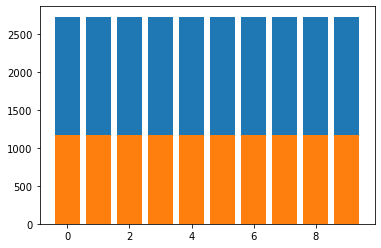

In [22]:
# Histogramme pour le train et le test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)
values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [23]:
#GTZAN Melspectrogram Generator
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

# CNN

In [24]:
#Définition de 4 couches pour le CNN 
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [25]:
#Définition du modèle

def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    
    #  Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [26]:
model = create_model(X_train[0].shape, 10)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 129, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 128, 129, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0     

In [28]:
#Loss Function
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [29]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [30]:
# Les générateurs (Generators)
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [31]:
#Entrainer le modèle en ajustant les paramètres et les hyperparamètre 
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=150,
    verbose=1,
    callbacks=[reduceLROnPlat])

C:\Users\YOOSURF\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
214/214 [==============================] - 272s 1s/step - loss: 18.2847 - accuracy: 0.1253 - val_loss: 5.7582 - val_accuracy: 0.1408
Epoch 2/150
214/214 [==============================] - 282s 1s/step - loss: 4.8260 - accuracy: 0.1298 - val_loss: 3.1507 - val_accuracy: 0.1712
Epoch 3/150
214/214 [==============================] - 288s 1s/step - loss: 2.9700 - accuracy: 0.1633 - val_loss: 2.4819 - val_accuracy: 0.1941
Epoch 4/150
214/214 [==============================] - 323s 1s/step - loss: 2.5013 - accuracy: 0.1734 - val_loss: 2.2936 - val_accuracy: 0.1799
Epoch 5/150
214/214 [==============================] - 275s 1s/step - loss: 2.2830 - accuracy: 0.2365 - val_loss: 2.1749 - val_accuracy: 0.1890
Epoch 6/150
214/214 [==============================] - 257s 1s/step - loss: 2.2512 - accuracy: 0.1927 - val_loss: 2.1203 - val_accuracy: 0.2179
Epoch 7/150
214/214 [==============================] - 242s 1s/step - loss: 2.1507 - accuracy: 0.2109 - val_loss: 2.1435 - val_accuracy

In [32]:
#Evaluer loss et l'accuracy 
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.023 and val_acc = 0.702


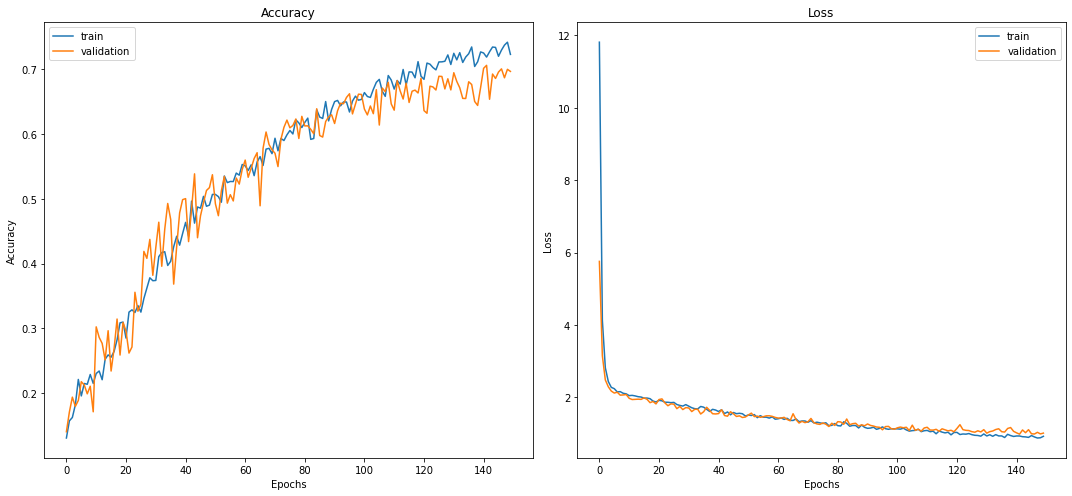

In [33]:
#Afficher la courbe d'Accuracy et le loss
#On remarque que l'apprentissage est effectué puisque les courbe d'accuracy du train et de test augmentent 
#et sont proches (Pas d'Overfitting)
#En meme temps la courbe du loss diminue 

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
#Afficher la matrice de corrélation pour etudier la dépendance entre les classes des genres musicaux 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


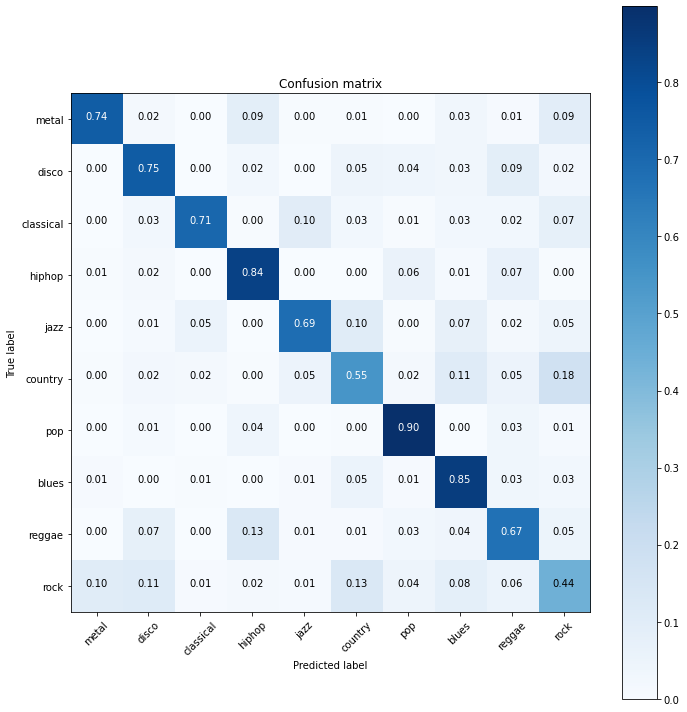

In [36]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))

plot_confusion_matrix(cm, keys, normalize=True)

In [37]:
#Vote Majoritaire 
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [38]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [39]:
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [40]:
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [41]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 0.793
